## Exploratory Data Analysis - Anti Cancer Peptides

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from scipy.stats import pearsonr

%matplotlib inline

Allow multiple outputs from each cell.

In [85]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load in train and test datasets.

In [86]:
df_train = pd.read_csv("../data/acp/train_data.csv")
df_test = pd.read_csv("../data/acp/test_data.csv")

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

train_per = round(100*(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])))
print(f"Train-test split: {train_per}% Train, {100-train_per}% Test")

Train dataset shape: (1378, 2)
Test dataset shape: (344, 2)
Train-test split: 80% Train, 20% Test


Take a look at the format of the data.

In [87]:
df_train.head()
df_train.dtypes
print(f"Unique values of label: {df_train.label.unique()}")

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


sequences    object
label         int64
dtype: object

Unique values of label: [0 1]


Check for distribution of classes to identify potential imbalances.

In [88]:
df_train.label.value_counts()
df_test.label.value_counts()
print("Both train and test datasets are perfectly balanced between the positive and negative class")

0    689
1    689
Name: label, dtype: int64

0    172
1    172
Name: label, dtype: int64

Both train and test datasets are perfectly balanced between the positive and negative class


### Sequence Sizes

Visualizing the distribution of the lengths of sequences in each dataset.

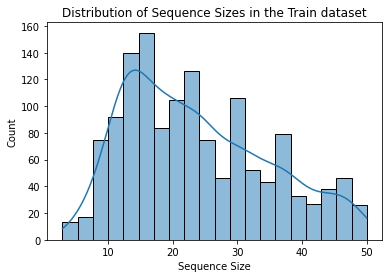

In [89]:
sns.histplot(df_train.sequences.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Train dataset');

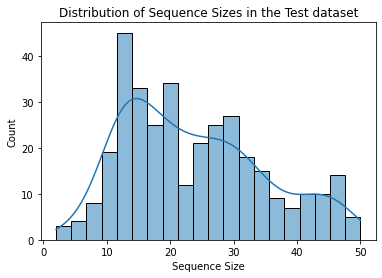

In [90]:
sns.histplot(df_test.sequences.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Test dataset');

In [91]:
train_seq_sizes = df_train.sequences.str.len()
test_seq_sizes = df_test.sequences.str.len()

print(f"Train dataset - mean of sequence sizes: {train_seq_sizes.mean()}")
print(f"Test dataset - mean of sequence sizes: {test_seq_sizes.mean()}")

print(f"Train dataset - smallest sequence size: {train_seq_sizes.min()}")
print(f"Test dataset - smallest sequence size: {test_seq_sizes.min()}")

print(f"Train dataset - largest sequence size: {train_seq_sizes.max()}")
print(f"Test dataset - largest sequence size: {test_seq_sizes.max()}")

Train dataset - mean of sequence sizes: 23.826560232220608
Test dataset - mean of sequence sizes: 23.75872093023256
Train dataset - smallest sequence size: 3
Test dataset - smallest sequence size: 2
Train dataset - largest sequence size: 50
Test dataset - largest sequence size: 50


### Checking for Duplicates

Making sure there are no duplicate proteins.

In [93]:
df_train.sequences.duplicated().sum()
df_test.sequences.duplicated().sum()

0

0

## Feature Engineering - Protein Features

In [139]:
def add_protein_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Make protein analysis object for each sequence
    df["protein_analysis"] = df["sequences"].map(ProteinAnalysis)

    # Extract protein features from analysis object column
    df["amino_acid_count"] = df["protein_analysis"].apply(lambda x: x.count_amino_acids())
    df["amino_acid_percent"] = df["protein_analysis"].apply(lambda x: x.get_amino_acids_percent())
    df["molecular_weight"] = df["protein_analysis"].apply(lambda x: x.molecular_weight())
    df["aromaticity"] = df["protein_analysis"].apply(lambda x: x.aromaticity())
    df["instability_index"] = df["protein_analysis"].apply(lambda x: x.instability_index())
    df["flexibility"] = df["protein_analysis"].apply(lambda x: x.flexibility())
    df["gravy"] = df["protein_analysis"].apply(lambda x: x.gravy())
    df["isoelectric_point"] = df["protein_analysis"].apply(lambda x: x.isoelectric_point())
    df["charge_at_pH"] = df["protein_analysis"].apply(lambda x: x.charge_at_pH(7.4)) # average pH in body
    df["secondary_structure_fraction"] = df["protein_analysis"].apply(lambda x: x.secondary_structure_fraction())
    df["molar_extinction_coefficient"] = df["protein_analysis"].apply(lambda x: x.molar_extinction_coefficient())
    
    # Drop protein analysis object column
    df = df.drop("protein_analysis", axis=1)

    return df

In [100]:
# Add protein features as columns
df_train = add_protein_features(df_train)
df_test = add_protein_features(df_test)

In [105]:
df_train.head()

,sequences,label,amino_acid_count,amino_acid_percent,molecular_weight,aromaticity,instability_index,flexibility,gravy,isoelectric_point,charge_at_pH,secondary_structure_fraction,molar_extinction_coefficient
0,RRWWRRWRRW,0,"{'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...","{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': ...",1699.9691,0.400000,352.680000,[0.9671428571428571],-3.060000,11.999968,5.557302,"(0.4, 0.0, 0.0)","(22000, 22000)"
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,"{'A': 2, 'C': 0, 'D': 1, 'E': 0, 'F': 1, 'G': ...","{'A': 0.07692307692307693, 'C': 0.0, 'D': 0.03...",2816.3054,0.115385,22.946154,"[0.9920833333333332, 1.017154761904762, 1.0339...",-0.230769,10.295295,4.579467,"(0.34615384615384615, 0.23076923076923078, 0.1...","(6990, 6990)"
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,"{'A': 8, 'C': 0, 'D': 1, 'E': 0, 'F': 0, 'G': ...","{'A': 0.23529411764705882, 'C': 0.0, 'D': 0.02...",3455.0584,0.029412,1.847059,"[0.9872261904761905, 0.9956904761904762, 1.039...",0.185294,10.001706,2.634853,"(0.20588235294117646, 0.14705882352941177, 0.4...","(5500, 5500)"
3,GLFDVIKKVAAVIGGL,1,"{'A': 2, 'C': 0, 'D': 1, 'E': 0, 'F': 1, 'G': ...","{'A': 0.125, 'C': 0.0, 'D': 0.0625, 'E': 0.0, ...",1599.9542,0.062500,14.187500,"[0.9886190476190477, 1.0280833333333335, 1.007...",1.443750,8.590944,0.552888,"(0.5, 0.1875, 0.25)","(0, 0)"
4,VAKLLAKLAKKVL,1,"{'A': 3, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...","{'A': 0.23076923076923078, 'C': 0.0, 'D': 0.0,...",1394.8306,0.000000,-10.361538,"[0.9979047619047619, 1.0209404761904763, 0.978...",1.030769,10.477676,3.513128,"(0.46153846153846156, 0.0, 0.5384615384615385)","(0, 0)"


In [110]:
df_train.dtypes

sequences                        object
label                             int64
amino_acid_count                 object
amino_acid_percent               object
molecular_weight                float64
aromaticity                     float64
instability_index               float64
flexibility                      object
gravy                           float64
isoelectric_point               float64
charge_at_pH                    float64
secondary_structure_fraction     object
molar_extinction_coefficient     object
dtype: object

### Amino Acid Frequencies/Composition

Confirm that 20 amino acids are present in our sequences.

In [102]:
amino_acids = set()
for protein in df_train.sequences:
    for acid in protein:
        amino_acids.add(acid)
print(amino_acids)
print(len(amino_acids))

{'Y', 'C', 'H', 'N', 'V', 'L', 'R', 'D', 'Q', 'I', 'S', 'T', 'A', 'G', 'E', 'K', 'P', 'M', 'F', 'W'}
20


Function to get average amino acid content in a series of sequences

In [141]:
def get_avg_amino_acid_count(df: pd.DataFrame, amino_acids: set or list) -> dict:
    # Initialize amino acid dict for all sequences
    am_acid_dict = dict.fromkeys(amino_acids, 0)

    for am_dict in df.amino_acid_count:
        for key in am_dict.keys():
            # If amino acid present in sequence
            if am_dict[key] != 0:
                am_acid_dict[key] = am_acid_dict.get(key) + am_dict[key]

    for key in am_acid_dict.keys():
        am_acid_dict[key] = am_acid_dict.get(key)/len(df_train)

    return am_acid_dict

In [142]:
acp_avg_acids = get_avg_amino_acid_count(df_train[df_train.sequences==1], amino_acids)
non_acp_avg_acids = get_avg_amino_acid_count(df_train[df_train.sequences==0], amino_acids)

<AxesSubplot:>

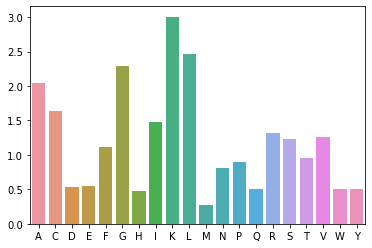

In [149]:
sns.barplot(x = sorted(acp_avg_acids.keys()), y = [acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())])

<AxesSubplot:>

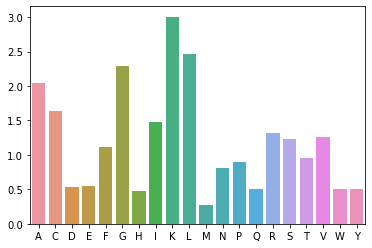

In [150]:
sns.barplot(x = sorted(non_acp_avg_acids.keys()), y = [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())])

In [154]:
pearsonr([acp_avg_acids.get(key) for key in sorted(acp_avg_acids.keys())],
            [non_acp_avg_acids.get(key) for key in sorted(non_acp_avg_acids.keys())])[0]

1.0

As seen in both the barplots of and correlation between the amino acid average counts of acp and non-acp proteins, there is no virtually no difference between the two, so this feature has zero predictive power for classifying ACPs and non-ACPs.

Function to get average percentage of amino acid for each sequence

In [ ]:
def get_avg_amino_acid_percent(df: pd.DataFrame, amino_acids: set or list) -> dict:
    # Initialize amino acid dict for all sequences
    am_acid_dict = dict.fromkeys(amino_acids, 0)

    for am_dict in df.amino_acid_count:
        for key in am_dict.keys():
            # If amino acid present in sequence
            if am_dict[key] != 0:
                am_acid_dict[key] = am_acid_dict.get(key) + am_dict[key]

    for key in am_acid_dict.keys():
        am_acid_dict[key] = am_acid_dict.get(key)/len(df_train)

    return am_acid_dict

In [ ]:
acp_avg_acids_percent = get_avg_amino_acid_percent(df_train[df_train.sequences==1], amino_acids)
non_acp_avg_acids_percentt = get_avg_amino_acid_percent(df_train[df_train.sequences==0], amino_acids)

In [ ]:
import Bio
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
alignments = pairwise2.align.globalxx(df_train.sort_values(by="sequences").sequences[0], df_train.sort_values(by="sequences").sequences[1])
print(format_alignment(*alignments[0]))

In [ ]:
# from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

In [ ]:
a = SeqRecord(df_train.sort_values(by="sequences").sequences[0])
b = SeqRecord(df_train.sort_values(by="sequences").sequences[1])
c = SeqRecord(df_train.sort_values(by="sequences").sequences[2])

In [ ]:
# align = MultipleSeqAlignment([a, b, c],
#                              annotations={"tool": "demo"},
#                              column_annotations={"stats": "CCCXCCC"})